## Name: 
Xiaojing Shen/xshen16@depaul.edu  
Serena Yang/myang43@depaul.edu  
Yue Hou/yhou14@depaul.edu
### Group 3 Check point 3: Recommender System

In [1]:
#package
import numpy as np
import pandas as pd

import gzip
from collections import defaultdict
import random
import numpy
import scipy.optimize

import matplotlib.pyplot as plt
from tqdm import tqdm
import time
from scipy import spatial
import operator

In [2]:
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
nltk.download(["punkt","stopwords","wordnet"])

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/serenayang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/serenayang/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/serenayang/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

#### Loading data from stage 2-web crawler from IMDB, Top 250 movies

In [3]:
reviews_250 = pd.read_csv('/Users/serenayang/Desktop/Group 3_Capstone Project/data/reviews_250.csv')
reviews_250 = reviews_250.iloc[1:,1:]
reviews_250.head()

Movie_title          user_name  rating_score rating_time  \
1  The Shawshank Redemption  TheLittleSongbird            10  2009-04-17   
2  The Shawshank Redemption         bkoganbing             9  2011-02-17   
3  The Shawshank Redemption     Leofwine_draca            10  2016-12-18   
4  The Shawshank Redemption    Michael_Elliott             8  2008-12-02   
5  The Shawshank Redemption        SnoopyStyle            10  2013-12-08   

   num_helpful                                             review  
1         0.75  Shawshank Redemption is without doubt one of t...  
2         0.72  None of the usual otherworld creatures that po...  
3         0.81  Based on a novella by Stephen King, this is be...  
4         0.68  Shawshank Redemption, The (1994)**** (out of 4...  
5         0.54  Andy Dufresne (Tim Robbins) is a banker convic...

In [4]:
reviews_250.shape

(272863, 6)

In [5]:
reviews_250.isnull().sum()

Movie_title     0
user_name       0
rating_score    0
rating_time     0
num_helpful     0
review          0
dtype: int64

In [6]:
reviews_250['user_name'].nunique()

161008

In [7]:
reviews_250['Movie_title'].nunique()

247

### Collaborative Filtering
#### Give recommendations to a user based on preferences of "similar" users

In [8]:
#create userid and movie_dictionary
movie_dic = {}
count = 0
for i in range(len(reviews_250)):
    if reviews_250.iloc[i, 0] not in movie_dic.values():
        movie_dic[count] = reviews_250.iloc[i, 0]
        count += 1

In [9]:
movie_dic

{0: 'The Shawshank Redemption',
 1: 'The Dark Knight',
 2: 'The Wolf of Wall Street',
 3: 'Avengers: Endgame',
 4: 'Interstellar',
 5: 'The Godfather',
 6: 'Jurassic Park',
 7: 'Fight Club',
 8: 'The Lord of the Rings: The Fellowship of the Ring',
 9: 'The Matrix',
 10: 'Pulp Fiction',
 11: 'Parasite',
 12: 'Inglourious Basterds',
 13: 'Joker',
 14: 'Inception',
 15: 'Avengers: Infinity War',
 16: 'Prisoners',
 17: "Schindler's List",
 18: 'Warrior',
 19: 'Forrest Gump',
 20: 'Star Wars: Episode IV - A New Hope',
 21: 'Gone Girl',
 22: 'Django Unchained',
 23: '12 Angry Men',
 24: 'Batman Begins',
 25: 'Spider-Man: Into the Spider-Verse',
 26: 'Whiplash',
 27: 'The Dark Knight Rises',
 28: 'Mad Max: Fury Road',
 29: 'The Father',
 30: 'Léon: The Professional',
 31: '1917',
 32: 'Se7en',
 33: 'Goodfellas',
 34: 'The Silence of the Lambs',
 35: 'Gladiator',
 36: 'The Lord of the Rings: The Return of the King',
 37: 'The Prestige',
 38: 'Shutter Island',
 39: 'Hacksaw Ridge',
 40: 'Requie

In [10]:
#transform review dataset into a set: {'user1':[movie rated score, 0:no rating score for this movie]}
def transferIntoList(reviews_250):
    userlist = {}

    for j in range(len(reviews_250)):
        user_name = reviews_250.iloc[j, 1]
        sublist = [0]*(len(movie_dic))
        if user_name in userlist:
            sublist = userlist[user_name]
            moviecode = list(movie_dic.keys())[list(movie_dic.values()).index(reviews_250.iloc[j, 0])]
            sublist[moviecode] = reviews_250.iloc[j, 2]
        else:
            moviecode = list(movie_dic.keys())[list(movie_dic.values()).index(reviews_250.iloc[j, 0])]
            sublist[moviecode] = reviews_250.iloc[j, 2]

        userlist[user_name] = sublist  
    
    return userlist

In [11]:
userlist = transferIntoList(reviews_250)
userlist

{'TheLittleSongbird': [10,
  8,
  0,
  0,
  6,
  10,
  9,
  9,
  9,
  9,
  10,
  0,
  5,
  0,
  7,
  9,
  8,
  10,
  10,
  9,
  10,
  9,
  0,
  10,
  9,
  0,
  9,
  9,
  0,
  0,
  10,
  10,
  10,
  10,
  10,
  9,
  10,
  8,
  9,
  8,
  9,
  10,
  0,
  9,
  8,
  10,
  5,
  9,
  10,
  10,
  10,
  10,
  4,
  9,
  10,
  10,
  10,
  8,
  10,
  9,
  10,
  9,
  10,
  10,
  10,
  10,
  9,
  0,
  10,
  10,
  10,
  10,
  10,
  0,
  0,
  10,
  0,
  10,
  10,
  0,
  5,
  9,
  10,
  10,
  0,
  8,
  0,
  0,
  10,
  10,
  10,
  10,
  8,
  10,
  10,
  0,
  10,
  10,
  0,
  10,
  8,
  0,
  10,
  9,
  9,
  0,
  0,
  10,
  10,
  0,
  10,
  10,
  0,
  0,
  7,
  10,
  10,
  9,
  10,
  9,
  10,
  10,
  10,
  9,
  10,
  4,
  0,
  10,
  9,
  9,
  7,
  9,
  0,
  0,
  0,
  10,
  0,
  0,
  0,
  9,
  10,
  0,
  0,
  9,
  0,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  10,
  9,
  10,
  9,
  10,
  10,
  0,
  10,
  10,
  10,
  9,
  10,
  10,
  10,
  9,
  0,
  8,
  10,
  10,
  10,
  10,
  10,
  9,
  0,
  0

In [12]:
#calculate cosine similarity
from numpy import dot
from numpy.linalg import norm

def CosineSimilarity(s1, s2):
    result = dot(s1, s2)/(norm(s1)*norm(s2))
    return result

In [13]:
#get most similar taset user
def mostSimilar(i, K, userlist, user):
    similarities = []
    for i2 in userlist:
        sim = CosineSimilarity(user, userlist[i2])
        similarities.append((sim, i2))
    similarities.sort(reverse=True)
    
    tempresult = similarities[:K]
    simUser = {}
    for i in range(K):
        simUser[tempresult[i][1]] = tempresult[i][0]
    return simUser, tempresult

In [14]:
#get mean rating score for each user
def meanRating(userlist, tempresult, K):
    meanRate = {}
    for i in range(K):
        user = tempresult[i][1]
        num = sum(userlist[user])
        denum = sum(1 for n in userlist[user]if n != 0)
        meanRate[user] = num/denum
    return meanRate

In [15]:
#predict the final score for target user for one movie 
def predict(targetMeanR, j, meanRate, similarUser):
    num = 0
    denum = 0
    result = 0
    for i in meanRate:
        if userlist[i][j] != 0:
            num += similarUser[i]*(userlist[i][j] - meanRate[i])
            denum += similarUser[i]
    
    if num != 0:
        result = targetMeanR + (num/abs(denum))
    return result

In [16]:
#get prediction for each non-rating movies and get top K movies with high predict scores
def collaborative(numlist, K, userlist):
    targetMeanR = sum(numlist)/len(numlist)

    #set defalut user list
    user = {}
    usertemp = [0] * len(movie_dic)
    for i in range(len(movie_dic)):
        if i in numlist:
            user[i] = 10
            usertemp[i] = 10
        else:
            user[i] = 0
            usertemp[i] = 0

    simUser, tempresult = mostSimilar(i, K, userlist, usertemp)
    meanRate = meanRating(userlist, tempresult, K)

    for j in range(len(user)):
        if user[j] == 0:
            user[j] = predict(targetMeanR, j, meanRate, simUser)

    new = dict(sorted(user.items(), key=lambda item: item[1], reverse=True))
    key = list(new.keys())
    count = 0
    collaborative_list = []
    for m in key:
        if m not in numlist:
            if count < K:
                print(movie_dic[m])
                collaborative_list.append(movie_dic[m])
                count += 1
            else:
                break
    
    return collaborative_list

In [17]:
#assume user rate "the Dark Knight" movie with 10 score, get 10 recommendation movies for the target user
numlist = [1]
K = 10
collaborative_list = collaborative(numlist, K, userlist)

The Shawshank Redemption
The Wolf of Wall Street
Avengers: Endgame
Interstellar
The Godfather
Jurassic Park
Fight Club
The Lord of the Rings: The Fellowship of the Ring
The Matrix
Pulp Fiction


#### with sentiment analysis, score range 1/2, predict by sentiment analysis

In [18]:
#load sentiment analysis dataset
sentiment_data = pd.read_csv('/Users/serenayang/Desktop/Group 3_Capstone Project/data/dataset_review_1.csv')

In [19]:
sentiment_data.head()

Unnamed: 0               Movie_title          user_name  rating_score  \
0           1  The Shawshank Redemption  TheLittleSongbird            10   
1           2  The Shawshank Redemption         bkoganbing             9   
2           3  The Shawshank Redemption     Leofwine_draca            10   
3           4  The Shawshank Redemption    Michael_Elliott             8   
4           5  The Shawshank Redemption        SnoopyStyle            10   

  rating_time  num_helpful                                             review  \
0  2009-04-17         0.75  Shawshank Redemption is without doubt one of t...   
1  2011-02-17         0.72  None of the usual otherworld creatures that po...   
2  2016-12-18         0.81  Based on a novella by Stephen King, this is be...   
3  2008-12-02         0.68  Shawshank Redemption, The (1994)**** (out of 4...   
4  2013-12-08         0.54  Andy Dufresne (Tim Robbins) is a banker convic...   

                                        clean_review  sentiment_key  
0  Shawshank Redemption is without doubt one of t...              2  
1  None of the usual otherworld creatures that po...              2  
2  Based on a novella by Stephen King, this is be...              2  
3  Shawshank Redemption, The (1994)**** (out of 4...              2  
4  Andy Dufresne (Tim Robbins) is a banker convic...              2

In [20]:
reviews_250.head()

Movie_title          user_name  rating_score rating_time  \
1  The Shawshank Redemption  TheLittleSongbird            10  2009-04-17   
2  The Shawshank Redemption         bkoganbing             9  2011-02-17   
3  The Shawshank Redemption     Leofwine_draca            10  2016-12-18   
4  The Shawshank Redemption    Michael_Elliott             8  2008-12-02   
5  The Shawshank Redemption        SnoopyStyle            10  2013-12-08   

   num_helpful                                             review  
1         0.75  Shawshank Redemption is without doubt one of t...  
2         0.72  None of the usual otherworld creatures that po...  
3         0.81  Based on a novella by Stephen King, this is be...  
4         0.68  Shawshank Redemption, The (1994)**** (out of 4...  
5         0.54  Andy Dufresne (Tim Robbins) is a banker convic...

In [21]:
#add sentiment_key into the reviews_250 table
reviews_250['sentiment_key'] = sentiment_data['sentiment_key']

In [22]:
reviews_250.head()

Movie_title          user_name  rating_score rating_time  \
1  The Shawshank Redemption  TheLittleSongbird            10  2009-04-17   
2  The Shawshank Redemption         bkoganbing             9  2011-02-17   
3  The Shawshank Redemption     Leofwine_draca            10  2016-12-18   
4  The Shawshank Redemption    Michael_Elliott             8  2008-12-02   
5  The Shawshank Redemption        SnoopyStyle            10  2013-12-08   

   num_helpful                                             review  \
1         0.75  Shawshank Redemption is without doubt one of t...   
2         0.72  None of the usual otherworld creatures that po...   
3         0.81  Based on a novella by Stephen King, this is be...   
4         0.68  Shawshank Redemption, The (1994)**** (out of 4...   
5         0.54  Andy Dufresne (Tim Robbins) is a banker convic...   

   sentiment_key  
1            2.0  
2            2.0  
3            2.0  
4            2.0  
5            2.0

In [23]:
#transform into a dictionary
def transferIntoList1(reviews_250):
    userlist = {}

    for j in range(len(reviews_250)):
        user_name = reviews_250.iloc[j, 1]
        sublist = [0]*(len(movie_dic))
        if user_name in userlist:
            sublist = userlist[user_name]
            moviecode = list(movie_dic.keys())[list(movie_dic.values()).index(reviews_250.iloc[j, 0])]
            sublist[moviecode] = reviews_250.iloc[j, -1]
        else:
            moviecode = list(movie_dic.keys())[list(movie_dic.values()).index(reviews_250.iloc[j, 0])]
            sublist[moviecode] = reviews_250.iloc[j, -1]

        userlist[user_name] = sublist  
    
    return userlist

In [24]:
userlist_1 = transferIntoList1(reviews_250)
userlist_1

{'TheLittleSongbird': [2.0,
  2.0,
  0,
  0,
  1.0,
  2.0,
  2.0,
  1.0,
  2.0,
  2.0,
  2.0,
  0,
  1.0,
  0,
  2.0,
  2.0,
  1.0,
  2.0,
  1.0,
  2.0,
  2.0,
  2.0,
  0,
  2.0,
  2.0,
  0,
  2.0,
  2.0,
  0,
  0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  1.0,
  2.0,
  2.0,
  2.0,
  2.0,
  0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  1.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  0,
  0,
  2.0,
  0,
  2.0,
  2.0,
  0,
  2.0,
  2.0,
  2.0,
  1.0,
  0,
  2.0,
  0,
  0,
  1.0,
  1.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  0,
  2.0,
  2.0,
  0,
  2.0,
  2.0,
  0,
  2.0,
  1.0,
  2.0,
  0,
  0,
  2.0,
  2.0,
  0,
  2.0,
  2.0,
  0,
  0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  2.0,
  0,
  2.0,
  1.0,
  1.0,
  2.0,
  2.0,
  0,
  0,
  0,
  2.0,
  0,
  0,
  0,
  2.0,
  2.0,
  0,
  0,
  2.0,
  0,
  2.0,
  1.0,
  2.0,
  2.0,
  2.0,

In [25]:
#get prediction for each non-rating movies and get top K movies with high predict scores
def collaborative(numlist, K, userlist):
    targetMeanR = sum(numlist)/len(numlist)

    #set defalut user list
    user = {}
    usertemp = [0] * len(movie_dic)
    for i in range(len(movie_dic)):
        if i in numlist:
            user[i] = 2
            usertemp[i] = 2
        else:
            user[i] = 0
            usertemp[i] = 0

    simUser, tempresult = mostSimilar(i, K, userlist, usertemp)
    meanRate = meanRating(userlist, tempresult, K)

    for j in range(len(user)):
        if user[j] == 0:
            user[j] = predict(targetMeanR, j, meanRate, simUser)

    new = dict(sorted(user.items(), key=lambda item: item[1], reverse=True))
    key = list(new.keys())
    count = 0
    collaborative_list = []
    for m in key:
        if m not in numlist:
            if count < K:
                print(movie_dic[m])
                collaborative_list.append(movie_dic[m])
                count += 1
            else:
                break
    
    return collaborative_list

In [26]:
#assume user rate "the Dark Knight" movie with 10 score, get 10 recommendation movies for the target user
numlist = [1]
K = 10
collaborative__sentiment_list = collaborative(numlist, K, userlist_1)

The Shawshank Redemption
The Wolf of Wall Street
Avengers: Endgame
Interstellar
The Godfather
Jurassic Park
Fight Club
The Lord of the Rings: The Fellowship of the Ring
The Matrix
Pulp Fiction


### Content-based Filtering
#### Give recommendations to a user based on items with "similar" content in the user's profile

#### Data process

In [27]:
df = pd.read_csv('/Users/serenayang/Desktop/Group 3_Capstone Project/data/df_IMDb.csv')
df.head()

Movie_title  \
0   Spider-Man: No Way Home   
1                      Dune   
2  The Shawshank Redemption   
3           The Dark Knight   
4             Jurassic Park   

                                         Movie_intro  rating  release_year  \
0  With Spider-Man's identity now revealed, Peter...     8.7          2021   
1  Feature adaptation of Frank Herbert's science ...     8.1          2021   
2  Two imprisoned men bond over a number of years...     9.3          1994   
3  When the menace known as the Joker wreaks havo...     9.0          2008   
4  A pragmatic paleontologist touring an almost c...     8.1          1993   

   review_num  Genre_Adventure  Genre_Sport  Genre_Comedy  Genre_Animation  \
0        5000                1            0             0                0   
1        5100                1            0             0                0   
2        9900                0            0             0                0   
3        7900                0            0             0                0   
4        1300                1            0             0                0   

   Genre_Western  ...  Genre_Family  Genre_Horror  Genre_Film-Noir  \
0              0  ...             0             0                0   
1              0  ...             0             0                0   
2              0  ...             0             0                0   
3              0  ...             0             0                0   
4              0  ...             0             0                0   

   Genre_Biography  Genre_War  Genre_Mystery  Genre_Musical  Genre_Music  \
0                0          0              0              0            0   
1                0          0              0              0            0   
2                0          0              0              0            0   
3                0          0              0              0            0   
4                0          0              0              0            0   

   Genre_Thriller  Genre_Crime  
0               0            0  
1               0            0  
2               0            0  
3               0            1  
4               0            0  

[5 rows x 26 columns]

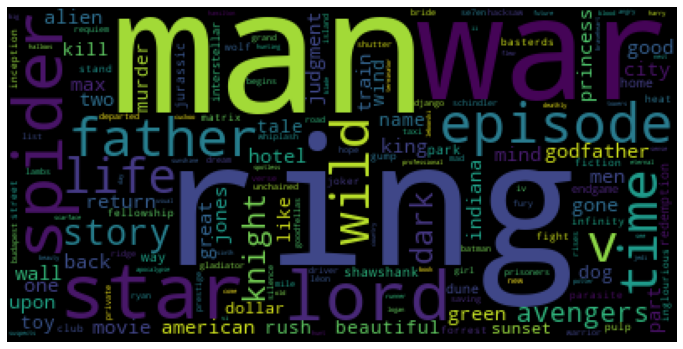

In [28]:
# word cloud
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re

def clean_text(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    return s
df['clean_title'] = df['Movie_title'].apply(clean_text)

text = df['clean_title'].to_string().lower()    
wordcloud = WordCloud(
    collocations=False,
    relative_scaling=0.5,
    stopwords=set(stopwords.words('english'))).generate(text)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

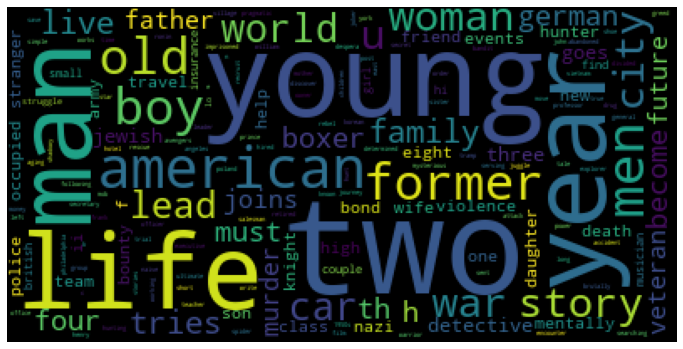

In [29]:
# word cloud
from nltk.corpus import stopwords
from wordcloud import WordCloud
import re

def clean_text(s):
    s = re.sub(r'http\S+', '', s)
    s = re.sub('(RT|via)((?:\\b\\W*@\\w+)+)', ' ', s)
    s = re.sub(r'@\S+', '', s)
    s = re.sub('&amp', ' ', s)
    return s
df['clean_intro'] = df['Movie_intro'].apply(clean_text)

text = df['clean_intro'].to_string().lower()    
wordcloud = WordCloud(
    collocations=False,
    relative_scaling=0.5,
    stopwords=set(stopwords.words('english'))).generate(text)

plt.figure(figsize=(12,12))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [30]:
df.head()

Movie_title  \
0   Spider-Man: No Way Home   
1                      Dune   
2  The Shawshank Redemption   
3           The Dark Knight   
4             Jurassic Park   

                                         Movie_intro  rating  release_year  \
0  With Spider-Man's identity now revealed, Peter...     8.7          2021   
1  Feature adaptation of Frank Herbert's science ...     8.1          2021   
2  Two imprisoned men bond over a number of years...     9.3          1994   
3  When the menace known as the Joker wreaks havo...     9.0          2008   
4  A pragmatic paleontologist touring an almost c...     8.1          1993   

   review_num  Genre_Adventure  Genre_Sport  Genre_Comedy  Genre_Animation  \
0        5000                1            0             0                0   
1        5100                1            0             0                0   
2        9900                0            0             0                0   
3        7900                0            0             0                0   
4        1300                1            0             0                0   

   Genre_Western  ...  Genre_Film-Noir  Genre_Biography  Genre_War  \
0              0  ...                0                0          0   
1              0  ...                0                0          0   
2              0  ...                0                0          0   
3              0  ...                0                0          0   
4              0  ...                0                0          0   

   Genre_Mystery  Genre_Musical  Genre_Music  Genre_Thriller  Genre_Crime  \
0              0              0            0               0            0   
1              0              0            0               0            0   
2              0              0            0               0            0   
3              0              0            0               0            1   
4              0              0            0               0            0   

                clean_title                                        clean_intro  
0   Spider-Man: No Way Home  With Spider-Man's identity now revealed, Peter...  
1                      Dune  Feature adaptation of Frank Herbert's science ...  
2  The Shawshank Redemption  Two imprisoned men bond over a number of years...  
3           The Dark Knight  When the menace known as the Joker wreaks havo...  
4             Jurassic Park  A pragmatic paleontologist touring an almost c...  

[5 rows x 28 columns]

### Glove

In [31]:
embeddings_dict = {}
with open('/Users/serenayang/Desktop/Group 3_Capstone Project/data/glove.6B.100d.txt', 'r') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], "float32")
        embeddings_dict[word] = vector

In [32]:
def encode_document(tokens):
    encoded = np.zeros(100)
    doclen = 0
    for word in tokens:
        if word.lower() in embeddings_dict:
            encoded += np.array(embeddings_dict[word.lower()])
            doclen += 1
    return encoded / doclen

In [33]:
def get_vector(df, column):
    result = []
    for text in df[column]:
        if len(text) > 0:
            tokens = nltk.tokenize.word_tokenize(text)
            enc = encode_document(tokens)
        else:
            enc = np.zeros(100)
        array_sum = np.sum(enc)
        if np.isnan(array_sum) == True:
          enc = np.zeros(100)
        result.append(enc)
    return result

In [34]:
clean_intro_vec = get_vector(df, "clean_intro")

In [35]:
clean_title_vec = get_vector(df, "clean_title")

<ipython-input-32-7216fb759116>:8: RuntimeWarning: invalid value encountered in true_divide
  return encoded / doclen


In [36]:
df1 = df

In [37]:
df1['intro_glove'] = clean_intro_vec
df1['title_glove'] = clean_title_vec
df1 = df1.drop(columns=['Movie_title','Movie_intro','clean_intro','clean_title'])
df1.head()

rating  release_year  review_num  Genre_Adventure  Genre_Sport  \
0     8.7          2021        5000                1            0   
1     8.1          2021        5100                1            0   
2     9.3          1994        9900                0            0   
3     9.0          2008        7900                0            0   
4     8.1          1993        1300                1            0   

   Genre_Comedy  Genre_Animation  Genre_Western  Genre_Sci-Fi  Genre_Fantasy  \
0             0                0              0             0              1   
1             0                0              0             0              0   
2             0                0              0             0              0   
3             0                0              0             0              0   
4             0                0              0             1              0   

   ...  Genre_Film-Noir  Genre_Biography  Genre_War  Genre_Mystery  \
0  ...                0                0          0              0   
1  ...                0                0          0              0   
2  ...                0                0          0              0   
3  ...                0                0          0              0   
4  ...                0                0          0              0   

   Genre_Musical  Genre_Music  Genre_Thriller  Genre_Crime  \
0              0            0               0            0   
1              0            0               0            0   
2              0            0               0            0   
3              0            0               0            1   
4              0            0               0            0   

                                         intro_glove  \
0  [-0.051199780095641204, 0.10018487833440304, 0...   
1  [-0.05173269929505433, 0.02852832550662711, 0....   
2  [0.18137909649383455, 0.1996465227788403, 0.29...   
3  [-0.07010505099647811, 0.02940008533852441, 0....   
4  [-0.07880164833890425, 0.120863755409782, 0.36...   

                                         title_glove  
0  [-0.107265804708004, 0.21862200498580933, 0.72...  
1  [-0.11726000159978867, 0.5692899823188782, -0....  
2  [0.6947953303654989, 0.12116699417432149, 0.27...  
3  [-0.04532399773597717, -0.11351666847864787, 0...  
4  [0.1217924989759922, 0.4929800033569336, 0.890...  

[5 rows x 26 columns]

In [38]:
df1.shape

(250, 26)

In [39]:
def convert_one_vector(df):
    new_array= np.zeros((df.shape[0], int(df.shape[1]-2+200)))
    for i in tqdm(range(df.shape[0])):
        new_vector = []
        for j in range(df.shape[1]):
            val = df.iloc[i][j]
            if isinstance(val, np.ndarray):
                val = val.tolist()
                new_vector += val
            else:
                new_vector.append(val) 
            my_array = np.array(new_vector)
        new_array[i] = my_array
    return new_array

In [40]:
df2 = convert_one_vector(df1)

100%|██████████| 250/250 [00:00<00:00, 380.73it/s]


In [41]:
df2 = pd.DataFrame(df2)
df2.head()

0       1       2    3    4    5    6    7    8    9    ...       214  \
0  8.7  2021.0  5000.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  ...  0.015931   
1  8.1  2021.0  5100.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  ...  0.024138   
2  9.3  1994.0  9900.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.267047   
3  9.0  2008.0  7900.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  ... -0.137596   
4  8.1  1993.0  1300.0  1.0  0.0  0.0  0.0  0.0  1.0  0.0  ...  0.046335   

        215       216       217       218       219       220       221  \
0 -0.121724  0.273236  0.147481 -0.690072 -0.336342 -0.021305 -0.335784   
1 -0.034992  0.221530  0.408660  1.018400 -0.070035 -0.145100 -0.214580   
2  0.085468 -0.485710  0.697780 -0.302906 -0.717840  0.557120  0.113187   
3 -0.187802 -0.096873  0.621847 -0.493270 -0.243098 -0.765403 -0.199117   
4 -1.052335 -0.010349  0.360125 -0.232500 -0.278460  0.007945 -0.416480   

        222       223  
0  0.532222  0.142812  
1 -0.128910  0.138860  
2  0.078727  0.425517  
3 -0.122263 -0.179413  
4  0.464691 -0.701025  

[5 rows x 224 columns]

In [42]:
previous_column_name = list(df1.columns)
column_name = previous_column_name[:-2]
for i in previous_column_name[-2:]:
  for j in range(100):
    new_name = str(i) + "_" + str(j)
    column_name.append(new_name)
print(column_name)

['rating', 'release_year', 'review_num', 'Genre_Adventure', 'Genre_Sport', 'Genre_Comedy', 'Genre_Animation', 'Genre_Western', 'Genre_Sci-Fi', 'Genre_Fantasy', 'Genre_History', 'Genre_Romance', 'Genre_Drama', 'Genre_Action', 'Genre_Family', 'Genre_Horror', 'Genre_Film-Noir', 'Genre_Biography', 'Genre_War', 'Genre_Mystery', 'Genre_Musical', 'Genre_Music', 'Genre_Thriller', 'Genre_Crime', 'intro_glove_0', 'intro_glove_1', 'intro_glove_2', 'intro_glove_3', 'intro_glove_4', 'intro_glove_5', 'intro_glove_6', 'intro_glove_7', 'intro_glove_8', 'intro_glove_9', 'intro_glove_10', 'intro_glove_11', 'intro_glove_12', 'intro_glove_13', 'intro_glove_14', 'intro_glove_15', 'intro_glove_16', 'intro_glove_17', 'intro_glove_18', 'intro_glove_19', 'intro_glove_20', 'intro_glove_21', 'intro_glove_22', 'intro_glove_23', 'intro_glove_24', 'intro_glove_25', 'intro_glove_26', 'intro_glove_27', 'intro_glove_28', 'intro_glove_29', 'intro_glove_30', 'intro_glove_31', 'intro_glove_32', 'intro_glove_33', 'intro_g

In [43]:
df2.columns = column_name
df2.head()

rating  release_year  review_num  Genre_Adventure  Genre_Sport  \
0     8.7        2021.0      5000.0              1.0          0.0   
1     8.1        2021.0      5100.0              1.0          0.0   
2     9.3        1994.0      9900.0              0.0          0.0   
3     9.0        2008.0      7900.0              0.0          0.0   
4     8.1        1993.0      1300.0              1.0          0.0   

   Genre_Comedy  Genre_Animation  Genre_Western  Genre_Sci-Fi  Genre_Fantasy  \
0           0.0              0.0            0.0           0.0            1.0   
1           0.0              0.0            0.0           0.0            0.0   
2           0.0              0.0            0.0           0.0            0.0   
3           0.0              0.0            0.0           0.0            0.0   
4           0.0              0.0            0.0           1.0            0.0   

   ...  title_glove_90  title_glove_91  title_glove_92  title_glove_93  \
0  ...        0.015931       -0.121724        0.273236        0.147481   
1  ...        0.024138       -0.034992        0.221530        0.408660   
2  ...       -0.267047        0.085468       -0.485710        0.697780   
3  ...       -0.137596       -0.187802       -0.096873        0.621847   
4  ...        0.046335       -1.052335       -0.010349        0.360125   

   title_glove_94  title_glove_95  title_glove_96  title_glove_97  \
0       -0.690072       -0.336342       -0.021305       -0.335784   
1        1.018400       -0.070035       -0.145100       -0.214580   
2       -0.302906       -0.717840        0.557120        0.113187   
3       -0.493270       -0.243098       -0.765403       -0.199117   
4       -0.232500       -0.278460        0.007945       -0.416480   

   title_glove_98  title_glove_99  
0        0.532222        0.142812  
1       -0.128910        0.138860  
2        0.078727        0.425517  
3       -0.122263       -0.179413  
4        0.464691       -0.701025  

[5 rows x 224 columns]

#### Content-based recommender system

In [44]:
def cosine_similarity(movie_id):
  similar_dic = {}
  for i in range(df2.shape[0]):
    if i != int(movie_id):
      result = 1 - spatial.distance.cosine(df2.loc[movie_id], df2.loc[i])
      similar_dic[i] = result
  return similar_dic

In [45]:
def recommender(movie_id):
  similar_dic = cosine_similarity(movie_id)
  #recommendation_index = sorted(similar_dic, key=similar_dic.get, reverse=True)[:3]
  recommendation_index = sorted(similar_dic, key=similar_dic.get, reverse=True)[:5]
  return recommendation_index

In [46]:
def user_input():
  user_input_genre = input("'Action','Adventure','Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'\nWhich is your favorite genre of movie? \n ")
  movie_list = df[df2["Genre_"+ user_input_genre]==1]["Movie_title"]
  print(movie_list.tolist())
  user_input = input("Which is your favorite movie?\n")
  index = find_movie_index(user_input)
  return index

In [47]:
def find_movie_title(index):
  list_of_movie_title = df['Movie_title'].to_list()
  return list_of_movie_title[index]

In [48]:
def find_movie_index(movie_title):
  list_of_movie_title = df['Movie_title'].to_list()
  movie_index = list_of_movie_title.index(movie_title)
  return movie_index

In [49]:
def main():
  recommendation_lst = []
  index = user_input()
  recommendation_index = recommender(index)
  recommendation_index
  for i in recommendation_index:
    recommendation_movie = find_movie_title(i)
    recommendation_lst.append(recommendation_movie)
  print("Here is the recommendation for you:\n ", recommendation_lst)

In [50]:
main()

'Action','Adventure','Animation', 'Biography', 'Comedy', 'Crime', 'Drama', 'Family', 'Fantasy', 'Film-Noir', 'History', 'Horror', 'Music', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Sport', 'Thriller', 'War', 'Western'
Which is your favorite genre of movie? 
 Action
['Spider-Man: No Way Home', 'Dune', 'The Dark Knight', 'Jurassic Park', 'Avengers: Endgame', 'The Lord of the Rings: The Fellowship of the Ring', 'Avengers: Infinity War', 'Heat', 'The Matrix', 'Inception', 'Warrior', 'The Dark Knight Rises', 'Spider-Man: Into the Spider-Verse', 'Gladiator', 'Batman Begins', '1917', 'The Lord of the Rings: The Return of the King', 'Star Wars: Episode IV - A New Hope', 'Mad Max: Fury Road', 'Léon: The Professional', 'Blade Runner', 'The Lord of the Rings: The Two Towers', 'Logan', 'Terminator 2: Judgment Day', 'Star Wars: Episode VI - Return of the Jedi', 'Aliens', 'Oldboy', 'Star Wars: Episode V - The Empire Strikes Back', 'Demon Slayer the Movie: Mugen Train', 'Indiana Jones and the Raide

### Rule-Based Filtering
#### Give recommendations to a user based on predefined(or learned ) rules

Next, we will compare the one movie ratings given by all users with another movie ratings given by all users.By comparing the correlation matrix between movies, we could find some correlation between movies from all user’s perspective.

In [51]:
class RecommendationSystem:
    def __init__(self):
        self.dataset = pd.read_csv("/Users/serenayang/Desktop/Group 3_Capstone Project/data/reviews_250.csv", engine='python', error_bad_lines=False, skiprows=[1])
        self.dataset = self.dataset.drop([self.dataset.columns[0]], axis=1)
    
    def get_movie_by_title(self,mv_title):
        return self.dataset.loc[rs.dataset['Movie_title']==mv_title,['Movie_title']].values[0][0]
    
    def based_on_ratings(self,Movie_title):
        avg_ratings = self.dataset.groupby("Movie_title")['rating_score'].mean()
        count = self.dataset.groupby("Movie_title")['rating_score'].count()
        dataset_based_on_ratings = pd.DataFrame({"rating":avg_ratings,"number of ratings":count})
        
        # create a table - rows are user names, columns are movie titles, and values are rating scores
        df = self.dataset.loc[:,["user_name","rating_score","Movie_title"]]
        users_movie_matrix = pd.pivot_table(df,columns='Movie_title',index='user_name',values='rating_score') 
        
        # correlation betweern users recently watched movie vs. remaining all other movies
        movie_watched = users_movie_matrix[self.get_movie_by_title(Movie_title)]
        li = []
        for i in range(len(users_movie_matrix.columns)):
            li.append(movie_watched.corr(users_movie_matrix.iloc[:,i]))
        li = pd.Series(li)
        
        # create a data frame based on correlation
        df = pd.DataFrame({"title": users_movie_matrix.columns,"Correlation": li,"number of ratings" : dataset_based_on_ratings["number of ratings"].values})
        # filter with number of ratings and sort the data frame with correlation column
        recommendation_set = df[df["number of ratings"] >= 50].sort_values(by=["Correlation","number of ratings"],ascending=False)
        
        # recommend movies with titles
        recommended_movies = recommendation_set["title"].values
        print("Movies with similar ratings like your input movie --->",self.get_movie_by_title(Movie_title),"<--- are",end="\n\n")
        
        for i in range(1,16):
            print(recommended_movies[i])
   
    def recommend(self,Movie_title=None):
        if Movie_title is None:
            print("Error! Please input your movie title")
        elif Movie_title is not None:
            self.based_on_ratings(Movie_title)

In [52]:
rs = RecommendationSystem()
rs.recommend(Movie_title= 'The Dark Knight')

Movies with similar ratings like your input movie ---> The Dark Knight <--- are

Miracle in Cell No. 7
Demon Slayer: Mugen Train
Z
Autumn Sonata
Hara-Kiri
The Departed
Dangal
Gangs of Wasseypur
La Haine
Like Stars on Earth
The Dark Knight Rises
Amélie
Andrei Rublev
3 Idiots
Ford v Ferrari
